# Working with Unknown Dataset Sizes

This notebook will demonstrate the features built into SmartNoise to handle unknown or private dataset sizes.

### Set up libraries and load exemplar dataset

In [1]:
# load libraries
import os
import opendp.smartnoise.core as sn
import numpy as np
import math
import statistics

# establish data information
data_path = os.path.join('.', 'data', 'PUMS_california_demographics_1000', 'data.csv')
var_names = ["age", "sex", "educ", "race", "income", "married"]

data = np.genfromtxt(data_path, delimiter=',', names=True)
age = list(data[:]['age'])

print("Dimension of dataset: " + str(data.shape))
print("Names of variables:   " + str(data.dtype.names))

Dimension of dataset: (1000,)
Names of variables:   ('age', 'sex', 'educ', 'race', 'income', 'married')


We see above this dataset has 1000 observations (rows).  Oftentimes the number of observations is public information.  For example, a researcher might run a random poll of 1000 respondents and publically announce the sample size.

However, there are cases where simply the number of observations itself can leak private information.  For example, if a dataset contained all the individuals with a rare disease in a community, then knowing the size of the dataset would reveal how many people in the community had that condition.  In general, a dataset maybe composed of some defined subset of a population, and the dataset size is then equivalent to a count query on that subset, and so we should protect it like any other query we want to provide privacy guarantees for.

SmartNoise assumes the sample size is private information.  If it happens that you actually know the dataset size, then that information will be valuable if you add it into your analysis graph.  However, SmartNoise will not assume you truthfully or correctly know the size of the dataset.  (Moreover, it can not directly send you an error message if you get this value incorrect, or this would permit an attack whereby an analyst keeps guessing different dataset sizes until the error message goes away, thereby leaking the exact dataset size.)

If we know the dataset size, we can incorporate it into the analysis as below, where we provide `data_n` as an argument to the release of a mean on age:

In [2]:
# get mean of age, using correct dataset size
with sn.Analysis() as analysis:
    # load data
    data = sn.Dataset(path = data_path, column_names = var_names)

    # get mean of age
    age_mean = sn.dp_mean(data = sn.to_float(data['age']),
                          privacy_usage = {'epsilon': .1},
                          data_lower = 0.,
                          data_upper = 100.,
                          data_rows = 1000       # Here we're providing the correct value of n.
                         )
analysis.release()

print("DP mean of age: {0}".format(age_mean.value))
print("Privacy usage: {0}".format(analysis.privacy_usage))


DP mean of age: 44.99578128095982
Privacy usage: approximate {
  epsilon: 0.1
}



<a id='providing-incorrect-dataset-size-values'></a>
### Providing incorrect dataset size values

However, if we provide an incorrect value of `data_n` we still receive an answer as we see below:

In [3]:
# get mean of age, using correct dataset size
with sn.Analysis() as analysis:
    # load data
    data = sn.Dataset(path = data_path, column_names = var_names)

    # get mean of age using too small n
    age_mean_low_n = sn.dp_mean(data = sn.to_float(data['age']),
                          privacy_usage = {'epsilon': .1},
                          data_lower = 0.,
                          data_upper = 100.,
                          data_rows = 900       # Here we're setting n below the actual value in the dataset.
                         )

    # get mean of age using too large n
    age_mean_high_n = sn.dp_mean(data = sn.to_float(data['age']),
                          privacy_usage = {'epsilon': .1},
                          data_lower = 0.,
                          data_upper = 100.,
                          data_rows = 1100       # Here we're setting n above the actual value in the dataset.
                         )
analysis.release()

print("DP mean of age: {0}".format(age_mean_low_n.value))
print("DP mean of age: {0}".format(age_mean_high_n.value))
print("Privacy usage: {0}".format(analysis.privacy_usage))

DP mean of age: 46.97731739598225
DP mean of age: 47.01770224968318
Privacy usage: approximate {
  epsilon: 0.2
}



Let's examine what is actually happening when these values are provided.  When we provide all of the metadata arguments (`data_lower`, `data_upper`, `data_n`) to the function `sn.dp_mean`, it works as a convenience method that knits together a number of library components to provide a mean.  A clamping, imputation and resize step are run on the dataset, in order for the validator to certify the analysis is privacy preserving (for more detail see the notebook "data_analysis_tutorial").

In [4]:
with sn.Analysis() as analysis:
    # load data
    data = sn.Dataset(path = data_path, column_names = var_names)
    
    # establish data 
    age_dt = sn.to_float(data['age'])
    
    # clamp data to range and impute missing values
    age_dt = sn.clamp(data = age_dt, lower = 0., upper = 100.)
    age_dt = sn.impute(data = age_dt, distribution = 'Gaussian',
                       lower = 0., upper = 100., shift = 45., scale = 10.)
    
    # ensure data are consistent with proposed n
    age_dt = sn.resize(data = age_dt, number_rows = 1000, distribution = 'Gaussian',
                       lower = 0., upper = 1000., shift = 45., scale = 10.)
    
    # calculate differentially private mean of age
    age_mean = sn.dp_mean(data = age_dt, privacy_usage = {'epsilon': .1})
    
analysis.release()

The `resize()` step takes `data` and `n` as arguments and builds a new dataset from the original data, with the number of rows equal to the supplied `n`.  This is done by two rules that guarantee the privacy of the analysis:
1. If `n` less than or equal to the size of the supplied data, sample `n` rows (without replacement) from the supplied dataset.
2. If `n` greater than the size of the supplied data, create a new dataset by using the entire supplied dataset, and adding the remaining required rows by imputing new observations as if they were missing values.

Thus, in general, we get the first `n` rows from the supplied dataset, and any additional rows are treated as if they were in the original data, but missing values.  

*(Note, we would get a better answer if we resampled any extra rows we needed from the dataset, instead of imputing them.  However, then an individual could appear in the dataset twice (or more), and this would change all of our worst-case sensitivity calculations in the differentially private mechanisms.  We plan to add this as an optional parameter to allow a user to inflate the sensitivity by a maximum value (and pay the corresponding privacy loss in their budget) in a future release.)*

We'll demonstrate the effects that resizing can have on differentially private releases at the end of this notebook, but first we show how to deal with the case where `data_n` is simply unknown.

### Analysis with no provided dataset size
If we do not believe we have an accurate estimate for `data_n` we can instead pay for a query on the dataset to release a differentially private value of the dataset size.  Then we can use that estimate in the rest of the analysis.  Here is an example:

In [5]:
# get mean of age, using DP release of dataset size as estimate
with sn.Analysis(dynamic=True) as analysis:
    # load data
    data = sn.Dataset(path = data_path, column_names = var_names)

    age_dt = sn.to_float(data['age'])
    
    # get dp release of the size of the dataset
    dp_num_records = sn.dp_count(data= age_dt,
                                 privacy_usage={'epsilon': .05},
                                 lower=0,
                                 upper=10000
                                )
    # get mean of age
    age_mean = sn.dp_mean(data = age_dt,
                          privacy_usage = {'epsilon': .1},
                          data_lower = 0.,
                          data_upper = 100.,
                          data_rows = dp_num_records   # Here we're providing the DP release of n.
                         )
analysis.release()
print("DP number of records: {0}".format(dp_num_records.value))
print("DP mean of age: {0}".format(age_mean.value))
print("Privacy usage: {0}".format(analysis.privacy_usage))

DP number of records: 1048
DP mean of age: 40.03917197882495
Privacy usage: approximate {
  epsilon: 0.15000000000000002
}



Note that our privacy usage has increased because we apportioned some epsilon for both the release count of the dataset, and the mean of the dataset.

The DP released estimate of the dataset size is a noisy answer.  As we saw above (in section [Providing incorrect dataset size values](#providing-incorrect-dataset-size-values)), if the DP released estimate happens to be too small, we will create a new dataset by subsampling from the `age` variable.  If the DP released estimate happens to be too large, we will add missing values to the column and impute.  Likely, the mean of the imputations is not the mean of the variable, so in this case, the answer will have some bias.  We can see this in simulation by plotting the number of records against the DP released mean through many simulations.  

*(Note, we're adjusting the epsilon for the dp count downwards to intentionally increase the range of released datasets sizes for dramatic visual effect in this simulation.)*

In [6]:
import matplotlib
import matplotlib.pyplot as plt

n_sims = 1000
history = np.zeros(shape=(n_sims, 2), dtype=float)

# loop over the previous release to accumulate many simulations
for i in range(n_sims):
    with sn.Analysis(dynamic=True) as analysis:
        data = sn.Dataset(path = data_path, column_names = var_names)
        age_dt = sn.to_float(data['age'])

        # get dp release of the size of the dataset
        dp_num_records = sn.dp_count(data= age_dt,
                                 privacy_usage={'epsilon': .05},
                                 lower=0,
                                 upper=10000
                                )
        # get mean of age
        age_mean = sn.dp_mean(data = age_dt,
                          privacy_usage = {'epsilon': 1},
                          data_lower = 0.,
                          data_upper = 100.,
                          data_rows = dp_num_records   # Here we're providing the DP release of n.
                         )
    analysis.release()
    history[i,0] = dp_num_records.value
    history[i,1] = age_mean.value

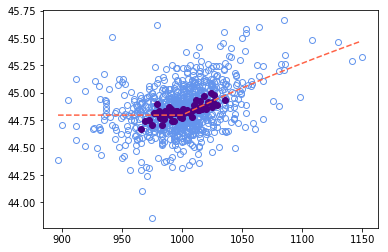

In [7]:
## plot the simulated values, 
## as well as their numerical average (for any dataset size > 6 simulations), 
## and finally the expected value.

# plot raw simulations
plt.plot(history[:, 0],history[:, 1], 'o', fillstyle='none', color = 'cornflowerblue')

min_count = int(min(history[:, 0]))
max_count = int(max(history[:, 0]))

count_range = range(int(min(history[:, 0])), int(max(history[:, 0])))
expected_values = np.zeros(shape=(len(count_range), 2), dtype=float)
expected_values[:, 0] = list(count_range)

data = np.genfromtxt(data_path, delimiter=',', names=True)
age = list(data[:]['age'])   
true_mean_age = statistics.mean(age)

counter = 0
for count in count_range:
    flag = history[:,0] == count
    subhistory = history[flag,1]
    if len(subhistory)>6:
        mean_sim = np.mean(subhistory)
        # plot average simulation by dp release of dataset size
        plt.plot(count, mean_sim, 'o', color = 'indigo')
    if count<=1000:
        expected_values[counter, 1] = true_mean_age
    else:
        expected_values[counter, 1] = ((true_mean_age* 1000) + ((count-1000)*50))/count
    counter += 1

# plot the expected value by dp release of dataset size
plt.plot(expected_values[:, 0], expected_values[:, 1], linestyle='--', color = 'tomato')
#plt.xlabel('DP Release of Age')
#plt.ylabel('n')
plt.show()

We observe a similar trend across a larger range of sample sizes.

In [8]:
import pandas as pd
import seaborn as sns

# initialize data
n_range = range(100, 2001, 200)
n_sims = 50
ns = []
releases = []

with sn.Analysis(dynamic=True) as analysis:
    data = sn.Dataset(path = data_path, column_names = var_names)
    age_dt = sn.to_float(data['age'])

    for n in n_range:
        for index in range(n_sims):
            # get mean of age
            ns.append(n)
            releases.append(sn.dp_mean(data = age_dt,
                              privacy_usage = {'epsilon': 1},
                              data_lower = 0.,
                              data_upper = 100.,
                              data_rows = n))
analysis.release()

# get released values
values = [release.value for release in releases]
df = pd.DataFrame({'n': ns, 'release': values})

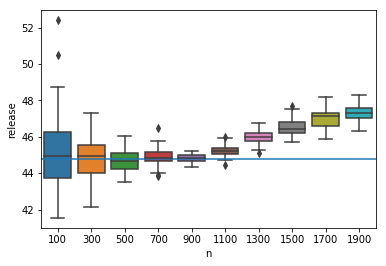

In [9]:
# get true mean
data = np.genfromtxt(data_path, delimiter=',', names=True)
age = list(data[:]['age'])   
true_mean_age = statistics.mean(age)

# plot distribution of releases by n
plot = sns.boxplot(x = 'n', y = 'release', data = df)
plot.axhline(true_mean_age)
plt.show()

### SmartNoise `resize` vs. other approaches
The standard formula for the mean of a variable is:
$\bar{x} = \frac{\sum{x}}{n}$

The conventional, and simpler, approach in the differential privacy literature, is to: 

1. compute a DP sum of the variable for the numerator
2. compute a DP count of the dataset rows for the denominator
3. take their ratio

This is sometimes called a 'plug-in' approach, as we are plugging-in differentially private answers for each of the terms in the original formula, without any additional modifications, and using the resulting answer as our estimate while ignoring the noise processes of differential privacy. While this 'plug-in' approach does result in a differentially private value, the utility here is generally lower than the solution in SmartNoise.  Because the number of terms summed in the numerator does not agree with the value in the denominator, the variance is increased and the resulting distribution becomes both biased and asymmetrical, which is visually noticeable in smaller samples.  Here's an example:

In [10]:
n_sims = 1000
history = np.zeros(shape=(n_sims, 2), dtype=float)

for i in range(n_sims):

    #  
    with sn.Analysis(dynamic=True) as analysis_plug_in:
        data = sn.Dataset(path = data_path, column_names = var_names)
        age_dt_1 = sn.to_float(data['age'])
        age_dt_2 = sn.to_float(data['age'])


        # get dp release of the size of the dataset
        dp_num_records = sn.dp_count(data= age_dt_1,
                                 privacy_usage={'epsilon': 0.5},
                                 lower=0,
                                 upper=10000
                                )

        clamped_age = sn.clamp(age_dt_2, lower=0., upper=100.)
        imputed_age = sn.impute(clamped_age)
        
        # get sum of age
        age_sum = sn.dp_sum(data = imputed_age,
                          privacy_usage = {'epsilon': 0.5}
                         )
    analysis_plug_in.release()
    # post-process
    dp_plugin_mean = age_sum.value/dp_num_records.value


    with sn.Analysis(dynamic=True) as analysis_smartnoise:
        # load data
        data = sn.Dataset(path = data_path, column_names = var_names)

        age_dt = sn.to_float(data['age'])
    
        # get dp release of the size of the dataset
        dp_num_records = sn.dp_count(data= age_dt,
                                 privacy_usage={'epsilon': 0.5},
                                 lower=0,
                                 upper=10000
                                )
        # get mean of age
        age_mean = sn.dp_mean(data = age_dt,
                          privacy_usage = {'epsilon': 0.5},
                          data_lower = 0.,
                          data_upper = 100.,
                          data_rows = dp_num_records   # Here we're providing the DP release of n.
                         )
    analysis_smartnoise.release()
    dp_smartnoise_mean = age_mean.value
    
    # store simulation results 
    history[i,0] = dp_plugin_mean
    history[i,1] = dp_smartnoise_mean
    
print("Plug-in mean privacy usage:    {0}".format(analysis_plug_in.privacy_usage))
print("SmartNoise mean privacy usage: {0}".format(analysis_smartnoise.privacy_usage))

Plug-in mean privacy usage:    approximate {
  epsilon: 1.0
}

SmartNoise mean privacy usage: approximate {
  epsilon: 1.0
}



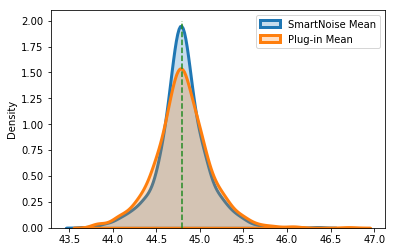

In [23]:
import seaborn as sns

data = np.genfromtxt(data_path, delimiter=',', names=True)
age = list(data[:]['age'])   
true_mean_age = statistics.mean(age)

fig, ax = plt.subplots()
sns.kdeplot(history[:, 1], fill=True, linewidth=3,
                 label = 'SmartNoise Mean')
sns.kdeplot(history[:, 0], fill=True, linewidth=3,
                 label = 'Plug-in Mean')

ax.plot([true_mean_age,true_mean_age], [0,2], linestyle='--', color = 'forestgreen')
#plt.xlabel('DP Release of Age')
#plt.ylabel('Density')
leg = ax.legend()


We see that for the same privacy loss, the distribution of answers from SmartNoise's resizing approach to the mean is much tighter around the true dataset value (thus lower in error) than the conventional plug-in approach.

*(Note, in these simulations, we've shown equal division of the epsilon for all constituent releases, but higher utility (lower error) can be generally gained by moving more of the epsilon into the sum, and using less in the count of the dataset rows, as in earlier examples.)*